In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
words = open("names.txt", 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [144]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [145]:
block_size = 3
X, Y = [], []
for w in words[:]:
    #print(w)
    context = [0]*block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:]+[ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [146]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [147]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [148]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [174]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,300),generator = g) # Each input is of size 3X2 = 6, Dimension of hidden layer is upto us, which is 100 here
b1 = torch.randn(300, generator = g)

W2 = torch.randn((300,27),generator = g) # Each input is of size 3X2 = 6, Dimension of hidden layer is upto us, which is 100 here
b2 = torch.randn(27,generator = g)
parameters = [C, W1, b1, W2, b2]

In [175]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [176]:
for p in parameters:
    p.requires_grad = True

In [177]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [184]:
lri = []
lossi = []

for i in range(3000):
    
    #mini-bath
    # get 32 numbers ranging from from 0-NumberOfDataPoints 
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    
    # forward pass
    emd = C[Xtr[ix]]
    h = torch.tanh(emd.view(-1,6) @W1 + b1) # -1 is 32 in this case
    logits = h@W2 + b2
    #counts = logits.exp()
    #prob = counts/counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean()
    # -- OR -- Use Pytorch's implementation of loss
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    #backward passs
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr*p.grad
   
    #lri.append(lre[i])
    #lossi.append(loss.item())
print(loss.item())    

3.2571492195129395


In [185]:
# use validation data
emd = C[Xdev]
h = torch.tanh(emd.view(-1,6) @W1 + b1) # -1 is 32 in this case
logits = h@W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.8492941856384277


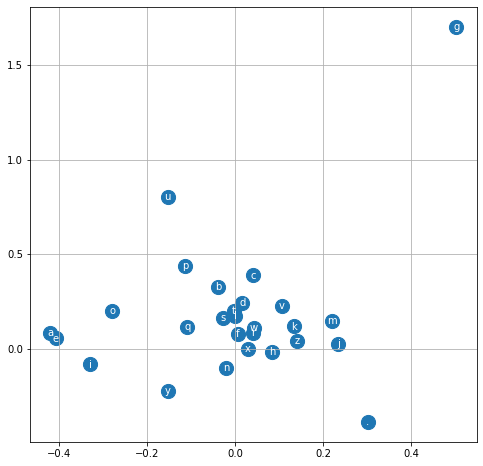

In [186]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


In [187]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amilll.
mhiigh.
xilh.
mahilaslic.
mahill.
maliya.
jigeni.
jhamari.
cimiiv.
malhiy.
dhli.
foin.
qailu.
salil.
mivin.
qiw.
jeloliiaryni.
fimiuzilslili.
diciil.


In [ ]:
# Since dev loss and traning loss are kind of equal, this means that we are not overfitting but our model - 
# -is very small

Text(0, 0.5, 'Loss')

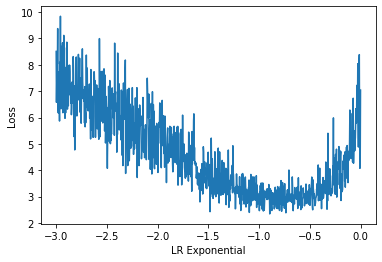

In [130]:
# decide the ideal learning rate here
plt.plot(lri, lossi)
plt.xlabel("LR Exponential")
plt.ylabel("Loss")